# Transmision Graphs
Transmission graphs for an integration. Cleaning WIP

In [1]:
from AD_analysis import *
import Atmospheric_diffraction as atm_shift
import numpy as np
import matplotlib as mpl
import Integ_analysis as int_analysis
import Transmission_calculation as trans_calc

The code mainly draws on the following steps, with key variables described:

>analysis=AD_analysis()

This gets the class

====
>analysis.load_band('LR','NIR','IY','H',sampling=1 * u.nm) 

This function loads the wavelengths that will be used for the shift calculations. 

First variable is LR or HR

Second variable is NIR or VIS

Third/fourth variables are the start/end bands. These can be the same, e.g. 'B', 'B'.

====
>analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])

OR
>analysis.load_airmasses(HA_range=[0,1,2],targ_dec= 0 * u.degree)
This function loads the airmasses to calculate the shifts for.

Can use 1) zenith angles (ZA_range)
OR 2) hour angles (HA_range); the declination is -25.3 deg by default, change with targ_dec=X

====
>analysis.calculate_shifts(aperturecentre_waveref = 1.1 * u.micron,reposition=True, guide_waveref=5 * u.micron)

This function calculates the shifts for the generated wavelengths and airmasses

aperturecentre_waveref is the aperture wavelength reference for original position

guide_waveref is the telescope Guide wavelength reference

reposition = TRUE or FALSE is a setting that determines whether the aperture is aligned on the aperture wavelength reference for each sequential airmass

====
>analysis.calculate_transmissions(method="numerical moffat") 

This function calculates the transmissions for the shifts using one of several methods

method can be 1) analytical gaussian, 2) numerical gaussian, 3) numerical moffat, or 4) numerical durham

====

These functions can be used in many ways for different plots/analysis of transmissions/shifts

Most of these function have other optional variables, e.g., scale for the numerical simulations, whether to change FWHM with airmass and wavelength. These are described in the relevant function notes

## Integration Transmission Graphs
### Transmission vs Wavelength for various aperture centres

In [2]:
#Following function plots integration transmission average for single mode observations
def plot_integ_trans(analysis,guide,aperture_centres,parallatic=True,normalise="no AD",centring=0):  
    """
    normalise: string, "none", "no ad"
        what to normalise the transmission to; either no normalisation, or relative to the no AD case (perfect ADC)

    """
    weights = np.arange(0, len(aperture_centres)+1)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)

    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_centres,guide,parallatic,centre_index=centring)
    
    plt.figure(figsize=[7,5])
    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_centres[count]),color=cmap.to_rgba(len(aperture_centres)-count))
        plt.ylabel("Mean Transmission")        
        plt.plot(analysis.output['wavelengths'],opt_transmission,label='No AD Transmission',color='black',linestyle='--')
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_centres[count]),color=cmap.to_rgba(len(aperture_centres)-count))
        plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
        plt.ylabel("Mean Transmission Relative to No AD")
        
    plt.legend()   
    plt.title("Guide = {}, HA {}-{}h, Dec = {}".format(guide,analysis.input['HA_range'][0],analysis.input['HA_range'][-1],analysis.input['targ_dec']))
    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")

Target goes below Horizon above/below HA of +/- 6.0h
Centred at HA = 1.0
Target goes below Horizon above/below HA of +/- 6.0h
Centred at HA = 1.5


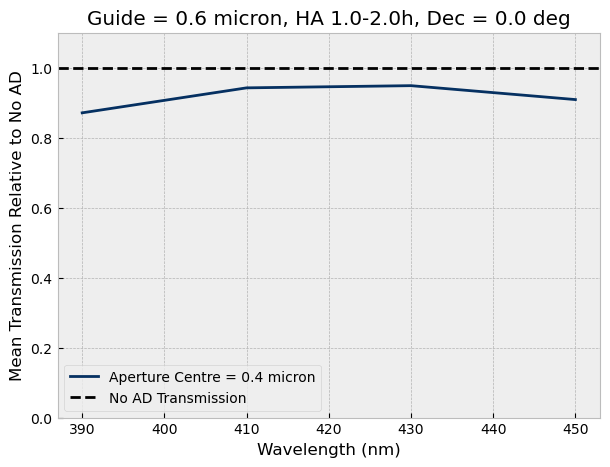

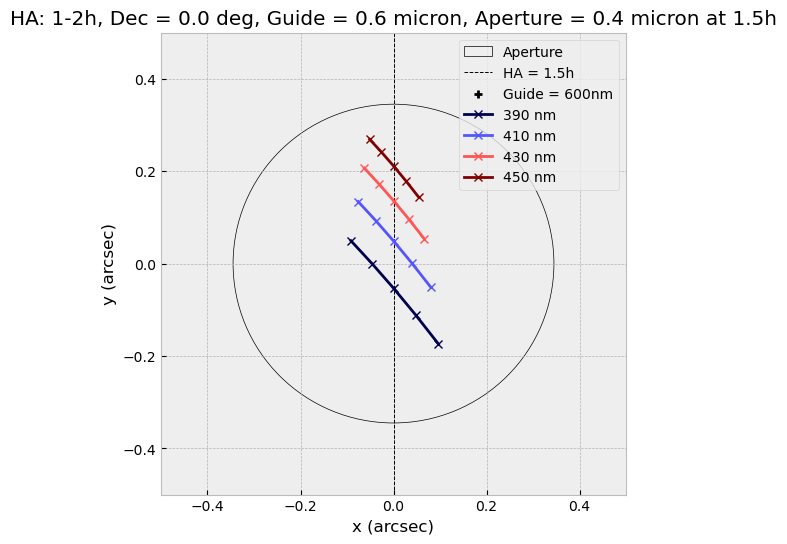

In [9]:
#Following is what is needed to plot the Trans vs Wavelength graphs for various aperture centres
#VIS
analysis=AD_analysis()
analysis.load_band('LR','VIS','B','B',sampling=20*u.nm) #Change for wanted observing mode

#HA:
targ_dec=0*u.deg
analysis.load_airmasses(HA_range=np.linspace(1,2,5),targ_dec=targ_dec)

#Aperture values to use:
aperture_centres=[.4]*u.micron
analysis.make_aperture("hexagons",method="numerical moffat")

#Guide in NIR:
guide=.6 * u.micron
plot_integ_trans(analysis,guide,aperture_centres,centring=0)

analysis=AD_analysis()
analysis.load_band('LR','VIS','B','B',sampling=20*u.nm) #Change for wanted observing mode
analysis.load_airmasses(HA_range=[1,1.25,1.5,1.75,2],targ_dec=targ_dec)
analysis.calculate_shifts(guide,aperture_centres[0],centring_index=2)
int_analysis.track_plot(analysis,y_axis="centring")


### Parallel Mode Graph

In [4]:
#Following function plots integration transmission average for parallel observations
def plot_integ_trans_parallel(analysis,aperture_B,aperture_V,aperture_R,aperture_NIR,guide,normalise="no AD",method="numerical moffat",aperture="circle",sample_val=[1*u.nm,1*u.nm],scale_val=0.01,parallatic=True,centring=0):  
    weights_r = np.arange(0, len(aperture_NIR)+2)
    norm_r = mpl.colors.Normalize(vmin=min(weights_r), vmax=max(weights_r))
    cmap_red = mpl.cm.ScalarMappable(norm=norm_r, cmap=mpl.cm.Purples)
    weights_b = np.arange(0, len(aperture_B)+2)
    norm_b = mpl.colors.Normalize(vmin=min(weights_b), vmax=max(weights_b))
    cmap_blue = mpl.cm.ScalarMappable(norm=norm_b, cmap=mpl.cm.Blues)
    weights_g = np.arange(0, len(aperture_V)+2)
    norm_g = mpl.colors.Normalize(vmin=min(weights_g), vmax=max(weights_g))
    cmap_green = mpl.cm.ScalarMappable(norm=norm_g, cmap=mpl.cm.Greens)
    weights_vr = np.arange(0, len(aperture_R)+2)
    norm_vr = mpl.colors.Normalize(vmin=min(weights_vr), vmax=max(weights_vr))
    cmap_vr = mpl.cm.ScalarMappable(norm=norm_vr, cmap=mpl.cm.Reds)
       
    analysis.load_band("LR","VIS","B","B",sampling=sample_val[0])
    analysis.make_aperture(aperture,method,scale_val)
    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_B,guide,parallatic,centring)

    plt.figure(figsize=[7,5])
    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_B[count]),color=cmap_blue.to_rgba(len(aperture_B)-count))
        plt.plot(analysis.output['wavelengths'],opt_transmission,color='black',linestyle='--')
        
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_B[count]),color=cmap_blue.to_rgba(len(aperture_B)-count))

    analysis.load_band("LR","VIS","V","V",sampling=sample_val[0])
    analysis.make_aperture(aperture,method,scale_val)
    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_V,guide,parallatic,centring)
    
    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_V[count]),color=cmap_green.to_rgba(len(aperture_V)-count))
        plt.plot(analysis.output['wavelengths'],opt_transmission,color='black',linestyle='--')
        
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_V[count]),color=cmap_green.to_rgba(len(aperture_V)-count))
            
    analysis.load_band("LR","VIS","R","R",sampling=sample_val[0])
    analysis.make_aperture(aperture,method,scale_val)
    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_R,guide,parallatic,centring)

    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_R[count]),color=cmap_vr.to_rgba(len(aperture_R)-count))
        plt.plot(analysis.output['wavelengths'],opt_transmission,color='black',linestyle='--')
        
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_R[count]),color=cmap_vr.to_rgba(len(aperture_R)-count))

    analysis.load_band("LR","NIR","IY","H",sampling=sample_val[1])
    analysis.make_aperture(aperture,method,scale_val)
    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_NIR,guide,parallatic,centring)

    if normalise == "none":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i),label='Aperture Centre = {}'.format(aperture_NIR[count]),color=cmap_red.to_rgba(len(aperture_NIR)-count))
        plt.ylabel("Mean Transmission")        
        plt.plot(analysis.output['wavelengths'],opt_transmission,label='No AD Transmission',color='black',linestyle='--')
    if normalise == "no AD":
        for count,i in enumerate(integ_transmissions):
            plt.plot(analysis.output['wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_NIR[count]),color=cmap_red.to_rgba(len(aperture_NIR)-count))
        plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
        plt.ylabel("Mean Transmission Relative to No AD")
        
    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")
    plt.axvline(x=guide.value*1000,color='black',linewidth=0.7,label='Guide Wavelength')
    if analysis.input['HA_range'] != []:
        plt.title("Guide = {}, HA {}-{}, Dec = {}, Centre at = {}h".format(guide,analysis.input['HA_range'][0],analysis.input['HA_range'][-1],analysis.input['targ_dec'],analysis.input['HA_range'][analysis.input['centring_index']]))
    plt.legend()
    



        

Target goes below Horizon above/below HA of +/- 6.0h
Centred at HA = 1.0
Centred at HA = 1.0
Centred at HA = 1.0
Centred at HA = 1.0


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:74: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


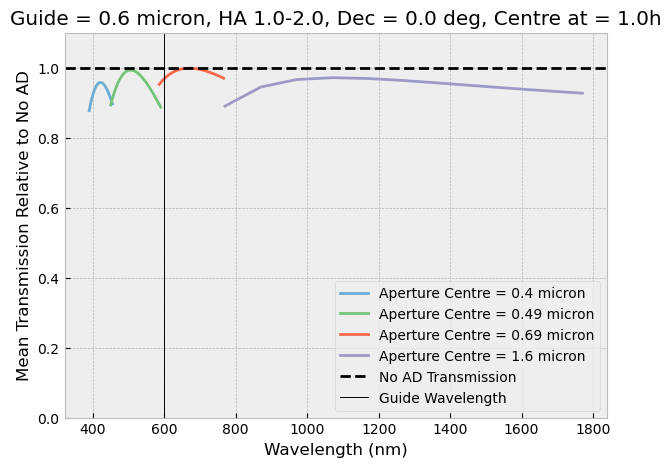

In [5]:
analysis=AD_analysis()

analysis.load_airmasses(HA_range=np.linspace(1,2,21),targ_dec=0*u.deg)

plot_integ_trans_parallel(analysis,[.4]*u.micron,[.49]*u.micron,[.69]*u.micron,[1.6]*u.micron,.6*u.micron,method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,100*u.nm],scale_val=0.01,centring=0)




Target goes below Horizon above/below HA of +/- 6.0h
Centred at HA = 1.5
Centred at HA = 1.5
Centred at HA = 1.5
Centred at HA = 1.5


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:74: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


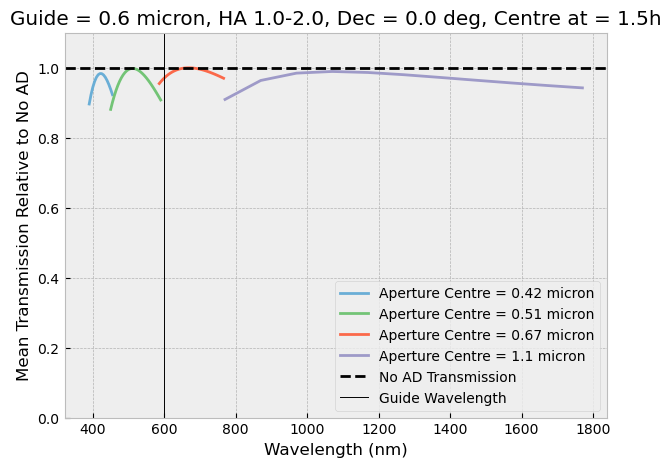

In [6]:
analysis=AD_analysis()
HA_range=np.linspace(1,2,21)
targ_dec=0*u.deg
centring=10
aperture_B=[.42]*u.micron
aperture_V=[.51]*u.micron
aperture_R=[.67]*u.micron
aperture_NIR=[1.1]*u.micron
guide=.6*u.micron

analysis.load_airmasses(HA_range=HA_range,targ_dec=targ_dec)
plot_integ_trans_parallel(analysis,aperture_B,aperture_V,aperture_R,aperture_NIR,guide,method="numerical moffat",aperture="hexagons",sample_val=[5*u.nm,100*u.nm],centring=centring)


Target goes below Horizon above/below HA of +/- 6.0h
Centred at HA = 1.5
Target goes below Horizon above/below HA of +/- 6.0h
Centred at HA = 1.5
Target goes below Horizon above/below HA of +/- 6.0h
Centred at HA = 1.5
Target goes below Horizon above/below HA of +/- 6.0h
Centred at HA = 1.5


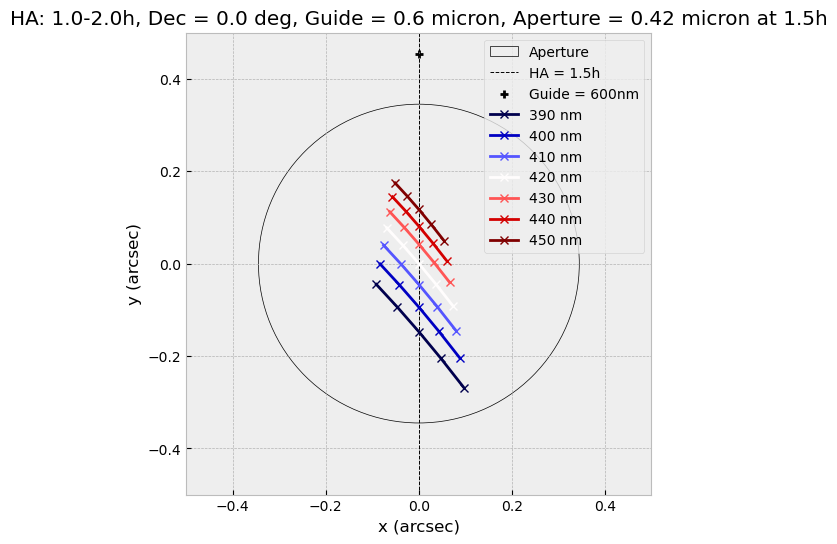

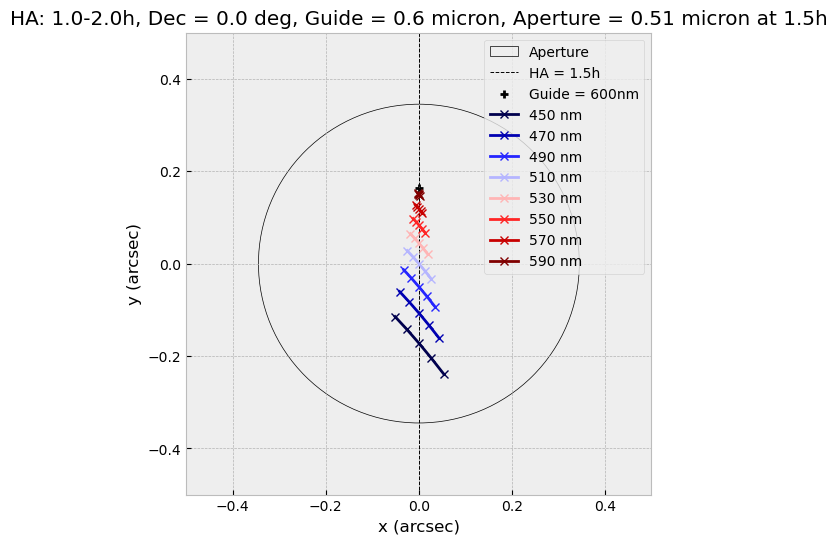

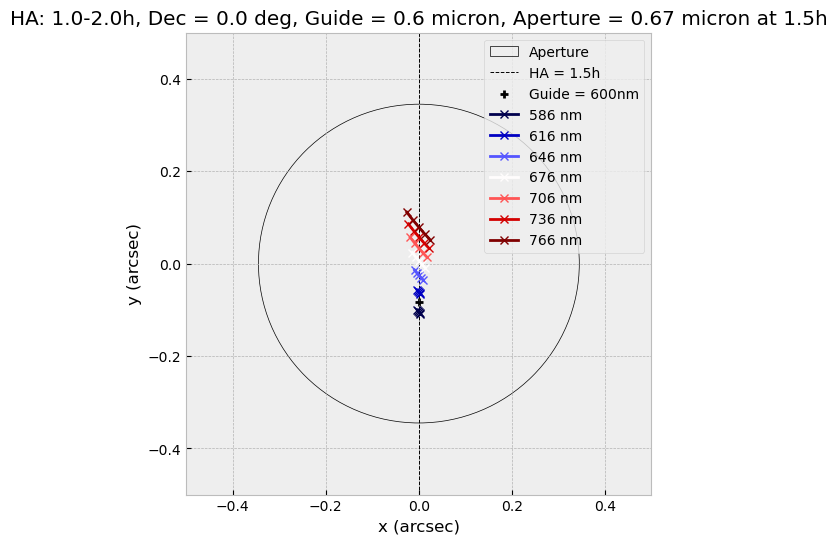

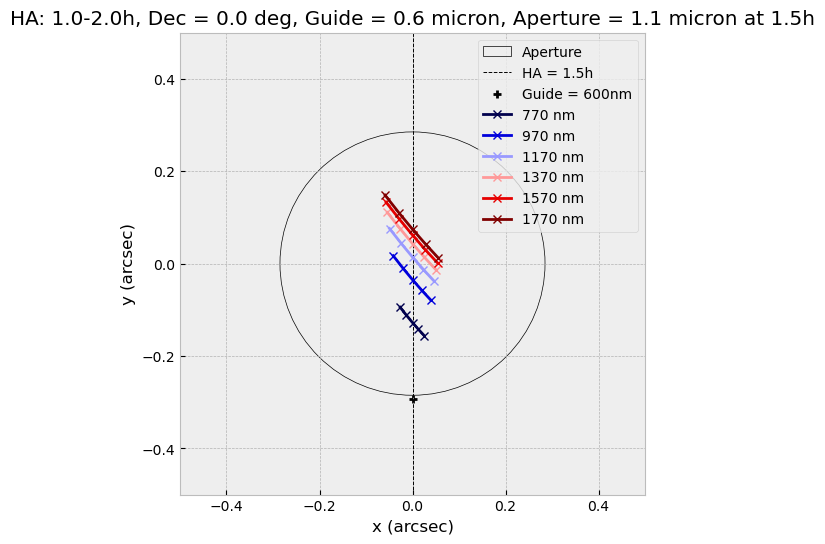

In [10]:
analysis=AD_analysis()
analysis.load_band('LR','VIS','B','B',sampling=10*u.nm) #Change for wanted observing mode
analysis.load_airmasses(HA_range=np.linspace(1,2,5),targ_dec=targ_dec)
analysis.calculate_shifts(guide,aperture_B[0],centring_index=2)
int_analysis.track_plot(analysis,y_axis="centring")

analysis=AD_analysis()
analysis.load_band('LR','VIS','V','V',sampling=20*u.nm) #Change for wanted observing mode
analysis.load_airmasses(HA_range=np.linspace(1,2,5),targ_dec=targ_dec)
analysis.calculate_shifts(guide,aperture_V[0],centring_index=2)
int_analysis.track_plot(analysis,y_axis="centring")

analysis=AD_analysis()
analysis.load_band('LR','VIS','R','R',sampling=30*u.nm) #Change for wanted observing mode
analysis.load_airmasses(HA_range=np.linspace(1,2,5),targ_dec=targ_dec)
analysis.calculate_shifts(guide,aperture_R[0],centring_index=2)
int_analysis.track_plot(analysis,y_axis="centring")

analysis=AD_analysis()
analysis.load_band('LR','NIR','IY','H',sampling=200*u.nm) #Change for wanted observing mode
analysis.load_airmasses(HA_range=np.linspace(1,2,5),targ_dec=targ_dec)
analysis.calculate_shifts(guide,aperture_NIR[0],centring_index=2)
int_analysis.track_plot(analysis,y_axis="centring")